Shown here are plots for Base Reflectivity (N0Q, 94) and Base Velocity (N0U, 99) using AWIPS data rendered with Matplotlib, Cartopy, and MetPy.  This example improves upon existing Level 3 Python rendering by doing the following:

* Display scaled and labeled colorbar below each figure.
* Plot radar radial images as coordinate maps in Cartopy and label with lat/lon.
* 8 bit Z and V colormap and data scaling added to MetPy from operational AWIPS. 
* Level 3 data are retrieved from the [Unidata EDEX Cloud server](http://unidata.github.io/awips2/docs/install/install-cave.html#how-to-run-cave) (`edex-cloud.unidata.ucar.edu`)
* Raw HDF5 byte data are converted to product values and scaled according to (page 3-34 https://www.roc.noaa.gov/wsr88d/PublicDocs/ICDS/2620001U.pdf)

        The threshold level fields are used to describe (up to) 256 levels as follows:
         halfword 31 contains the minimum data value in m/s*10 (or dBZ*10)
         halfword 32 contains the increment in m/s*10 (or dBZ*10)
         halfword 33 contains the number of levels (0 - 255) 

According to the [ICD for the Product Specification](https://www.roc.noaa.gov/WSR88D/PublicDocs/NewTechnology/B17_2620003W_draft.pdf), *"the 256 data levels of the digital product cover a range of reflectivity between -32.0 to +94.5 dBZ, in increments of 0.5 dBZ. Level codes 0 and 1 correspond to 'Below Threshold' and 'Range Folded', respectively, while level codes 2 through 255 correspond to the reflectivity data itself"*.

So it's really 254 color values between -32 and +94.5 dBZ.

The ICD lists 16 specific color levels and directs 256-level reflectivity products to use corresponding colors, leaving it the rendering application to scale and blend between the 16 color values, and to make decisions about discrete color changes, apparently.
![](http://i.imgur.com/cqphoe3.png)

For AWIPS, the National Weather Service uses a mostly-blended color scale with a discrete jump to red at reflectivity values of 50 dBZ:
 
![](http://i.imgur.com/o18gmio.png)

50 dBZ corresponds to the 16-level color *light red* (**FF6060**). Note that `FF6060` is not used in the NWS AWIPS color scale, instead RGB value is given as `255,0,0` (hex code **FF0000**). 60 dBZ is not quite exactly where white starts, but it makes sense that it would.  Obviously the AWIPS D2D authors took some liberties with their 256-level rendering, not adhering strictly to "dark red" for dBZ values between 60-65 (white was for 70 dBZ and above on the 16-level colormap).  For this exercise we will assume 50 dBZ should be red and 60 dBZ white, and 75 dBZ cyan.

**Python Script**

Download this script as a [Jupyter Notebook](http://nbviewer.jupyter.org/github/Unidata/python-awips/blob/master/examples/notebooks/NEXRAD_Level_3_Plot_with_Matplotlib.ipynb).

In [1]:
from awips.dataaccess import DataAccessLayer
from awips import ThriftClient, RadarCommon
from dynamicserialize.dstypes.com.raytheon.uf.common.time import TimeRange
from dynamicserialize.dstypes.com.raytheon.uf.common.dataplugin.radar.request import GetRadarDataRecordRequest
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from metpy.plots import ctables
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# set EDEX server and radar site definitions
site = 'kftg'
edexServer = '149.165.156.89'
DataAccessLayer.changeEDEXHost(edexServer)
request = DataAccessLayer.newDataRequest()
request.setDatatype('radar')
request.setLocationNames(site)

# Get latest time for site
datatimes = DataAccessLayer.getAvailableTimes(request)
dateTimeStr = str(datatimes[-1])
#dateTimeStr = "2017-02-02 03:53:03"
buffer = 60 # seconds
dateTime = datetime.strptime(dateTimeStr, '%Y-%m-%d %H:%M:%S')
# Build timerange +/- buffer
beginRange = dateTime - timedelta(0, buffer)
endRange = dateTime + timedelta(0, buffer)
timerange = TimeRange(beginRange, endRange)

# GetRadarDataRecordRequest to query site with timerange
client = ThriftClient.ThriftClient(edexServer)
request = GetRadarDataRecordRequest()
request.setTimeRange(timerange)
request.setRadarId(site)

# Map config
def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(12, 12),
            subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

# ctable defines the colortable, beginning value, data increment
#  * For N0Q the scale is -20 to +75 dBZ in increments of 0.5 dBZ
#  * For N0U the scale is -100 to +100 kts in increments of 1 kt
nexrad = {}
nexrad["N0Q"] = {
    'id': 94, 
    'unit':'dBZ', 
    'name':'0.5 deg Base Reflectivity', 
    'ctable': ['NWSStormClearReflectivity',-20., 0.5], 
    'res': 1000.,
    'elev': '0.5'
}
nexrad["N0U"] = {
    'id': 99, 
    'unit':'kts', 
    'name':'0.5 deg Base Velocity', 
    'ctable': ['NWS8bitVel',-100.,1.], 
    'res': 250.,
    'elev': '0.5'
}
grids = []
for code in nexrad:
    request.setProductCode(nexrad[code]['id'])
    request.setPrimaryElevationAngle(nexrad[code]['elev'])
    response = client.sendRequest(request)
    
    if response.getData():
        for record in response.getData():
            # Get record hdf5 data
            idra = record.getHdf5Data()
            rdat,azdat,depVals,threshVals = RadarCommon.get_hdf5_data(idra)
            dim = rdat.getDimension()
            lat,lon = float(record.getLatitude()),float(record.getLongitude())
            radials,rangeGates = rdat.getSizes()
            
            # Convert raw byte to pixel value
            rawValue=np.array(rdat.getByteData())
            array = []
            for rec in rawValue:
                if rec<0:
                    rec+=256
                array.append(rec)
                
            if azdat:
                azVals = azdat.getFloatData()
                az = np.array(RadarCommon.encode_radial(azVals))
                dattyp = RadarCommon.get_data_type(azdat)
                az = np.append(az,az[-1])

            header = RadarCommon.get_header(record, format, rangeGates, radials, azdat, 'description')
            rng = np.linspace(0, rangeGates, rangeGates + 1)

            # Convert az/range to a lat/lon
            from pyproj import Geod
            g = Geod(ellps='clrk66')
            center_lat = np.ones([len(az),len(rng)])*lat   
            center_lon = np.ones([len(az),len(rng)])*lon
            az2D = np.ones_like(center_lat)*az[:,None]
            rng2D = np.ones_like(center_lat)*np.transpose(rng[:,None])*nexrad[code]['res']
            lons,lats,back=g.fwd(center_lon,center_lat,az2D,rng2D)
            bbox = [lons.min(), lons.max(), lats.min(), lats.max()]
            
            # Create 2d array
            multiArray = np.reshape(array, (-1, rangeGates))
            data = ma.array(multiArray)
            
            # threshVals[0:2] contains halfwords 31,32,33 (min value, increment, num levels)
            data = ma.array(threshVals[0]/10. + (multiArray)*threshVals[1]/10.)
            
            if nexrad[code]['unit'] == 'kts':
                data[data<-63] = ma.masked
                data *= 1.94384 # Convert to knots
            else:
                data[data<=((threshVals[0]/10.)+threshVals[1]/10.)] = ma.masked
            
            # Save our requested grids so we can render them multiple times
            product = {
                "code": code,
                "bbox": bbox,
                "lats": lats,
                "lons": lons,
                "data": data
            }
            grids.append(product)
            
print("Processed "+str(len(grids))+" grids.")

Processed 2 grids.


## Plot N0Q and N0U with Cartopy

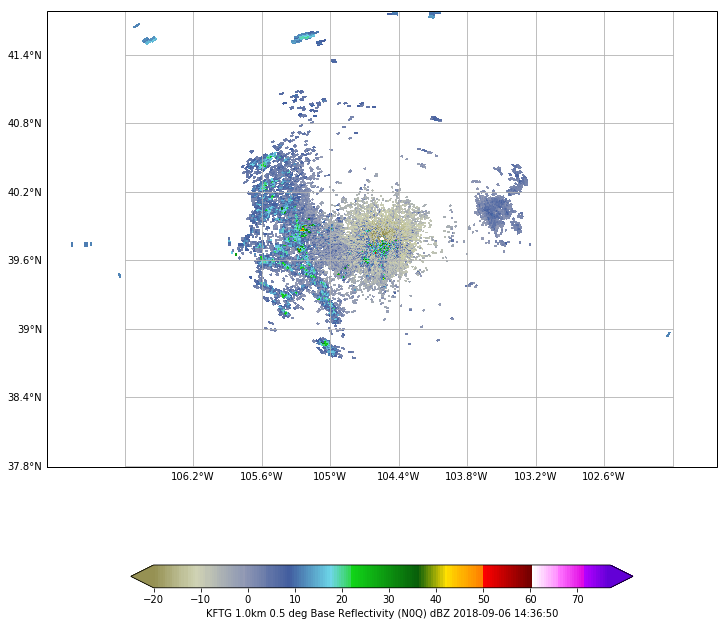

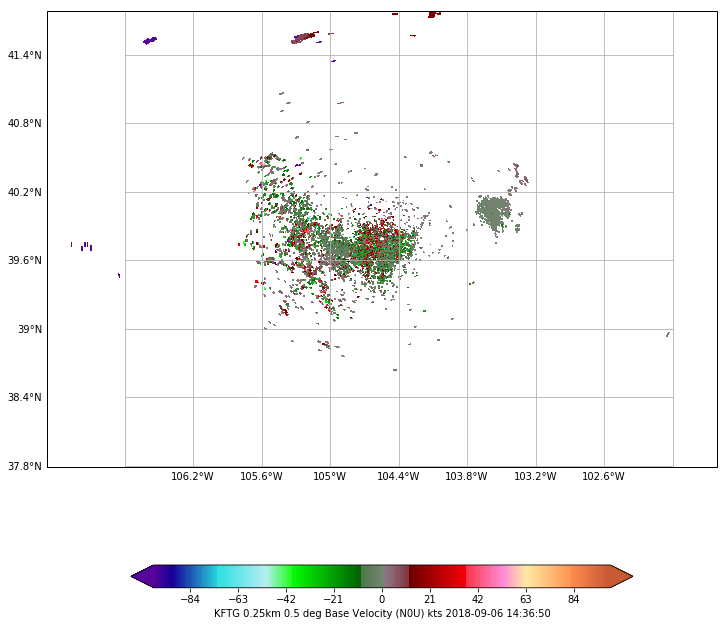

In [2]:
for rec in grids:
    code = rec["code"]
    bbox = rec["bbox"]
    lats = rec["lats"]
    lons = rec["lons"]
    data = rec["data"]
    # Create figure
    %matplotlib inline
    fig, ax = make_map(bbox=bbox)
    # Colortable filename, beginning value, increment
    ctable = nexrad[code]['ctable'][0]
    beg = nexrad[code]['ctable'][1]
    inc = nexrad[code]['ctable'][2]

    norm, cmap = ctables.registry.get_with_steps(ctable, beg, inc)
    cs = ax.pcolormesh(lons, lats, data, norm=norm, cmap=cmap)
    ax.set_aspect('equal', 'datalim')

    cbar = plt.colorbar(cs, extend='both', shrink=0.75, orientation='horizontal')
    cbar.set_label(site.upper()+" "+ str(nexrad[code]['res']/1000.) +"km " \
                   +nexrad[code]['name']+" ("+code+") " \
                   +nexrad[code]['unit']+" " \
                   +str(record.getDataTime()))

    # Zoom to within +-2 deg of center
    ax.set_xlim(lon-2., lon+2.)
    ax.set_ylim(lat-2., lat+2.)

    plt.show()

compare with the same product scan rendered in AWIPS CAVE (slightly different projections and still some color mapping differences, most noticeable in ground clutter).

![](http://i.imgur.com/q7zPRod.gif)

# Two-panel plot, zoomed in

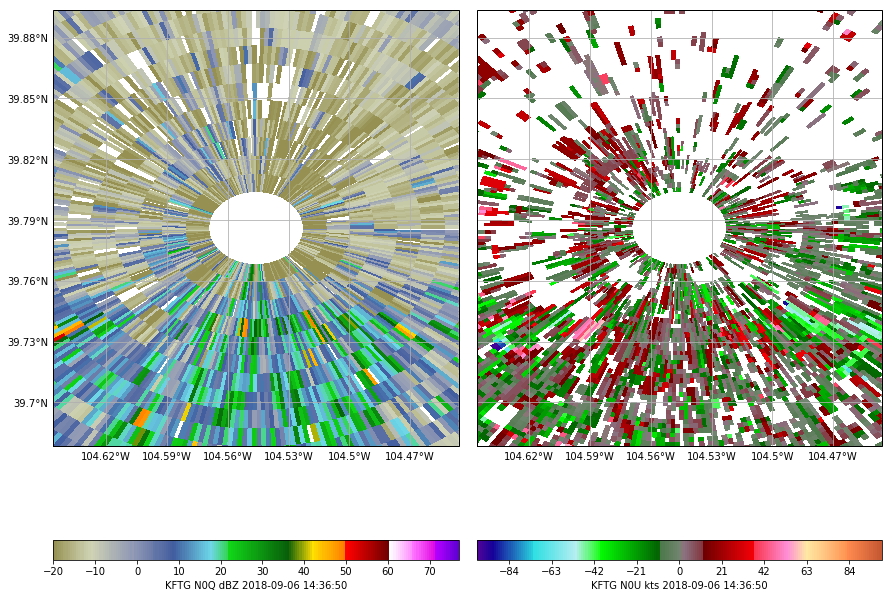

In [3]:
fig, axes = plt.subplots(ncols=2,figsize=(12,9),
             subplot_kw=dict(projection=ccrs.PlateCarree()))
i=0
for rec,ax in zip(grids, axes):
    
    code = rec["code"]
    bbox = rec["bbox"]
    lats = rec["lats"]
    lons = rec["lons"]
    data = rec["data"]
    
    # Create figure
    ax.set_extent(bbox)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    if i>0: gl.ylabels_left = False # hide right-pane left axis label
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    # Colortable filename, beginning value, increment
    colorvals=nexrad[code]['ctable']
    ctable = nexrad[code]['ctable'][0]
    beg = nexrad[code]['ctable'][1]
    inc = nexrad[code]['ctable'][2]

    norm, cmap = ctables.registry.get_with_steps(ctable, beg, inc)
    cs = ax.pcolormesh(lons, lats, data, norm=norm, cmap=cmap)
    ax.set_aspect('equal', 'datalim')
    cbar = fig.colorbar(cs, orientation='horizontal', ax=ax)
    cbar.set_label(site.upper()+" "+code+" "+nexrad[code]['unit']+" "+str(record.getDataTime()))
    plt.tight_layout()
    
    # Zoom
    ax.set_xlim(lon-.1, lon+.1)
    ax.set_ylim(lat-.1, lat+.1)
    i+=1

and again compared to CAVE

![](http://i.imgur.com/YSr7sKB.png)